# Overall Summary

There are too much data to be fed into to later model development. Hence, feature selection is required here.

Firstly, we group the features based on whether their missing values are happening together. This results multiple pages for example v1 until v11 are related via their missing values.

Since it is computationally infeasible to compute the correlation matrix of all 300++ vesta rich features, we compute correlation matrix of smaller pages that are found earlier. From that, we futher group the features based correlation value (i.e.: see `naive_reduce` function). Counting and temporal attributes are also grouped via this correlation selection approach.

For identity dataset, we see that that identity info and fraudelent transaction are not strongly correlated (neither positve nor negative). Furthermore, not all identity info are provided, then we decide not to include them as input features for model developed.

EDA is seperated into 2 parts, first part focuses on correlation selection, while second part focuses on preprocessing.

- [x] TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- [x] TransactionAMT: transaction payment amount in USD
- [x] ProductCD: product code, the product for each transaction
- [x] card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- [x] addr: address
- [x] dist: distance
- [x] P_ and (R__) emaildomain: purchaser and recipient email domain
- [x] C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- [x] D1-D15: timedelta, such as days between previous transaction, etc.
- [x] M1-M9: match, such as names on card and address, etc.
- [x] Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# Utility Functions

In [2]:
def flatten_list(li):
    from functools import reduce
    return reduce(lambda acm,cur: acm + cur, li)

def union_lists(lists):
    from functools import reduce
    return reduce(lambda acm, cur: acm.union(set(cur)), lists, set())

def naive_reduce(cor_mat, cor_p = 0.9):
    xs = set(cor_mat.columns)
    ys = set(cor_mat.index)
    subsets = []
    while xs != set():
        cur_col = xs.pop()
        mask = abs(cor_mat[cur_col]) > cor_p
        sel_set = list(mask[mask].index)
        if cur_col not in sel_set: 
            sel_set.append(cur_col)
        subsets.append(sel_set)
        xs = xs.difference(sel_set)
        ys = ys.difference(sel_set)
        # note that correlation matrix is symetric
        cor_mat = cor_mat.loc[ys][xs]

    return subsets

def get_suffix_digit(s):
    for i, _ in enumerate(s):
        if s[i:].isdigit():
            return i, int(s[i:]), s[:i]
        
def sort_prefix_numeric(seq):
    'same prefix'
    idx, _, prefix = get_suffix_digit(seq[0])
    mp = lambda c : int(c[idx:])
    res = [mp(s) for s in seq]
    res = sorted(res)
    return [f'{prefix}{s}' for s in res]

def nan_groups(df):
    nan_res = df.isna().sum()
    
    arg_unique = lambda seq, k: list(seq[seq == k].index)

    nan_nonzero_counts = np.delete(nan_res.unique(), 0)

    nan_grp = {c:arg_unique(nan_res, c) for c in nan_nonzero_counts}
    nan_grp = {c:grp for c,grp in nan_grp.items() if len(grp) > 1}

    for c, grp in nan_grp.items():
        blank_row_count = df[grp].isna().all(axis=1).sum()
        assert(blank_row_count==c) # ensure that nan happens together
    nan_grp = list(nan_grp.values())
    return nan_grp

In [3]:
# the file is very large, then read some of it
from zipfile import ZipFile
with ZipFile('ieee-fraud-detection.zip', 'r') as f:
    transaction_df = pd.read_csv(f.open('train_transaction.csv'))
    transaction_df.index = transaction_df['TransactionID']
    transaction_df = transaction_df.drop('TransactionID', axis=1)

In [4]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 393 entries, isFraud to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.7+ GB


In [5]:
transaction_df.shape, transaction_df['isFraud'].value_counts() / transaction_df['isFraud'].count() * 100

((590540, 393),
 0    96.500999
 1     3.499001
 Name: isFraud, dtype: float64)

"TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183."

In [6]:
def local_cell_main():
    offset_TransactionDT = transaction_df['TransactionDT'] - 86400
    last_dt = max(offset_TransactionDT.describe()) / 86400
    return {
        last_dt // 30: 'months' , 
        last_dt % 30: 'days'
    }
local_cell_main()

{6.0: 'months', 1.9992013888888778: 'days'}

### Transaction

Text(0.5, 1.0, 'Fraud Transaction vs Time')

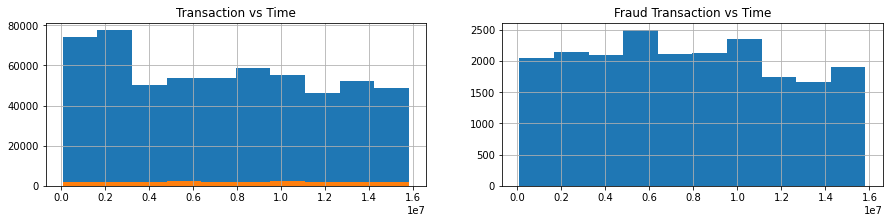

In [7]:
fig, axs = plt.subplots(ncols=2,figsize=(15,3))
transaction_df.groupby(by='isFraud')['TransactionDT'].hist(ax=axs[0]); axs[0].set_title('Transaction vs Time')
transaction_df['TransactionDT'][transaction_df['isFraud'].astype('bool')].hist(ax=axs[1]); axs[1].set_title('Fraud Transaction vs Time')

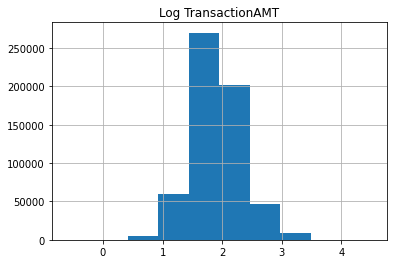

In [8]:
np.log10(transaction_df[['TransactionAmt']]).hist();plt.title('Log TransactionAMT');

### ProductCD

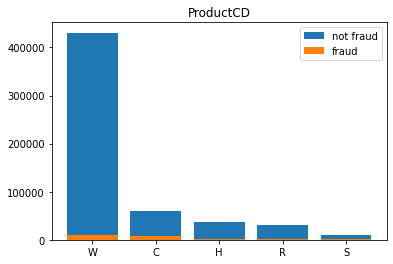

In [9]:
def local_cell_main():
    res = transaction_df.groupby(by='isFraud')['ProductCD'].value_counts()
    plt.title('ProductCD')
    plt.bar(res[1].index, res[0], label='not fraud')
    plt.bar(res[1].index, res[1], label='fraud')
    plt.legend()
local_cell_main()

### Email domain

In [10]:
transaction_df['R_emaildomain'].isna().sum(), transaction_df['P_emaildomain'].isna().sum(), len(transaction_df)

(453249, 94456, 590540)

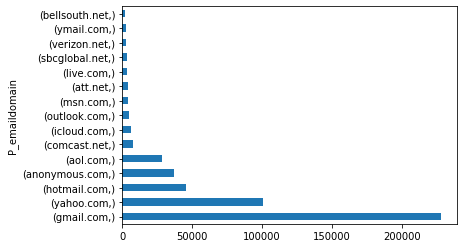

In [11]:
transaction_df[['P_emaildomain']].value_counts().head(15).plot.barh();

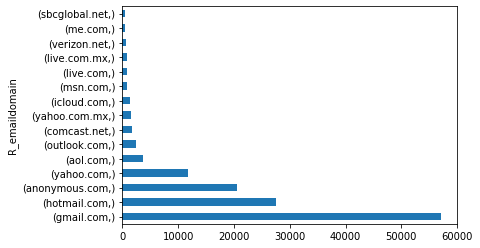

In [12]:
transaction_df[['R_emaildomain']].value_counts().head(15).plot.barh();

### distance, addr

Note that addr1, addr2 are categorical, but addr2 is pretty much the same across the column (i.e.: no information), hence it is discarded.

<AxesSubplot:>

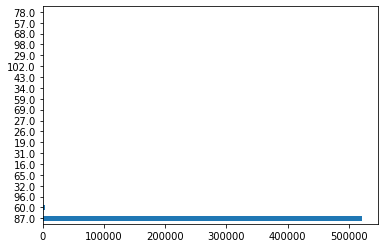

In [13]:
transaction_df['addr2'].value_counts().head(20).plot.barh() 

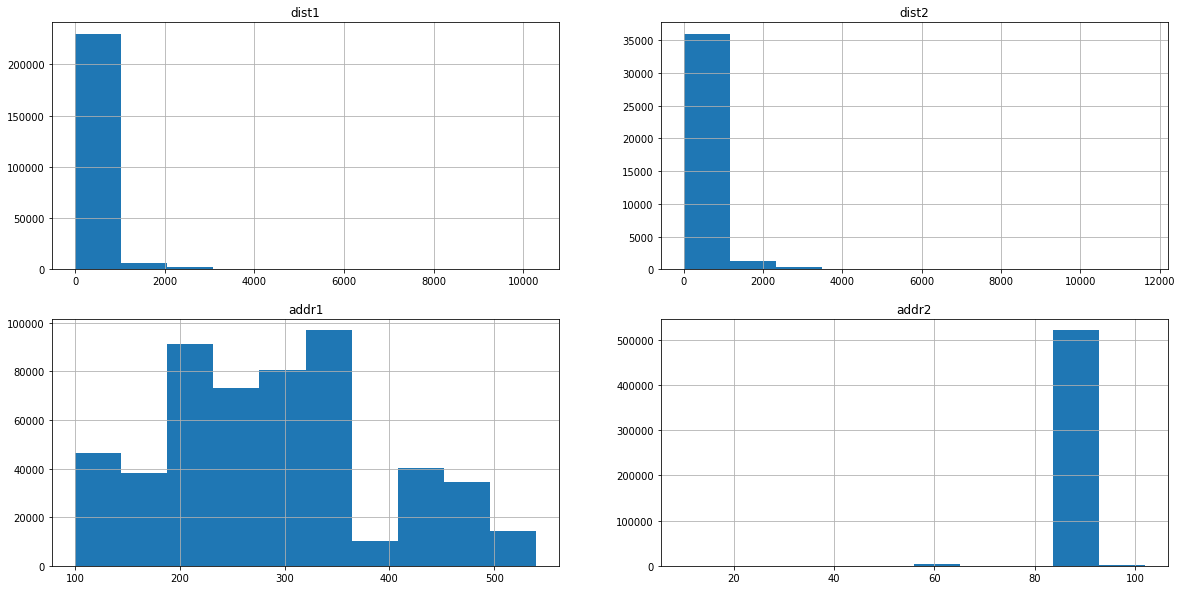

In [14]:
def local_cell_main():
    _, axs = plt.subplots(nrows = 2, ncols=2, figsize=(20,10))
    cols = ['dist1', 'dist2', 'addr1', 'addr2']
    for col, ax in zip(cols, axs.flatten()):
        transaction_df[col].hist(ax = ax)
        ax.set_title(col)
local_cell_main()

In [15]:
def vesta_col_sel(cols, prefix):
    return [c for c in cols if c.startswith(prefix)]
def vesta_grouping(df):

    f = lambda pre : vesta_col_sel(df.columns, pre)

    vesta_col_grp = {
        'counting' : f('C'),
        'timedelta' : f('D'),
        'match' : f('M'),
        'features': f('V'),
        'addr' : f('addr'),
        'dist': f('dist'),
        'email': ['P_emaildomain', 'R_emaildomain'],
        'card' : f('card'),
        'transaction':f('Transaction'),
        'addr' : f('addr')
    }

    remaining_col = set(df.columns) - union_lists(vesta_col_grp.values())
    vesta_col_grp['remaining'] = list(remaining_col)

    # check
    cur_cols = union_lists(vesta_col_grp.values())
    prv_cols = set(df.columns)
    assert(cur_cols == prv_cols)
    
    return vesta_col_grp

vesta_col_grp = vesta_grouping(transaction_df)
print(vesta_col_grp)

{'counting': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'], 'timedelta': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'], 'match': ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], 'features': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102',

# Structally Same via NAN

In [16]:
transaction_nan_grp = nan_groups(transaction_df)
len(transaction_nan_grp)

19

In [17]:
def extract_prefixes(seq):
    return set([s[0] for s in seq])
def arg_pred(seq, pred):
    return [c for c,s in enumerate(seq) if pred(s)]
def argcol_mix(seqs):
    major = [extract_prefixes(s) for s in seqs]
    return [seq for seq, mjr in zip(seqs, major) if len(mjr) > 1]
def is_consec(ns):
    res = np.diff(sorted(ns))
    return res[res==1].all()

In [18]:
def local_cell_main():
    prefixes = [extract_prefixes(seq) for seq in transaction_nan_grp]
    idxs = arg_pred(prefixes, lambda s: 'V' not in s)
    pred_f = lambda grp: 'V' not in extract_prefixes(grp)
    return list(filter(pred_f, transaction_nan_grp))

nan_other_grp = local_cell_main()
nan_other_grp

[['addr1', 'addr2'], ['D8', 'D9'], ['M1', 'M2', 'M3'], ['M8', 'M9']]

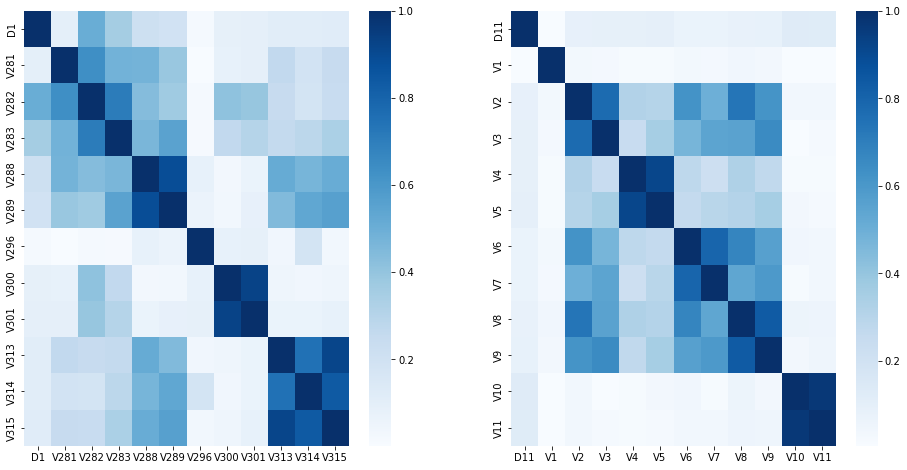

In [19]:
def local_cell_main():
    prefixes = [extract_prefixes(seq) for seq in transaction_nan_grp]
    idxs = arg_pred(prefixes, lambda s: 'V' in s and len(s) > 1)

    _, axs = plt.subplots(ncols=2,figsize=(16, 8))

    for i, ax in zip(idxs, axs):
        cols = transaction_nan_grp[i]
        cor = transaction_df[cols].corr()
        sns.heatmap(abs(cor), ax=ax, cmap='Blues')
local_cell_main()

D1 is related to V281 ~ V315 groups

D11 is related to V1 ~ V11

However, they are not really correlated with the V's groups. Hence, D1, D11 are discarded from V's groups

In [20]:
def local_cell_main():

    prefixes = [extract_prefixes(seq) for seq in transaction_nan_grp]
    idxs = arg_pred(prefixes, lambda s: 'V' in s and len(s) > 1)
    
    for i in idxs:
        seq = transaction_nan_grp[i]
        remains = [s for s in seq if s.startswith('D')]
        transaction_nan_grp[i] = [s for s in seq if not s.startswith('D')]
        
        if remains not in nan_other_grp:
            nan_other_grp.append(remains) # avoid repeatly adding
local_cell_main()
nan_other_grp

[['addr1', 'addr2'],
 ['D8', 'D9'],
 ['M1', 'M2', 'M3'],
 ['M8', 'M9'],
 ['D1'],
 ['D11']]

In [21]:
def check_vesta_rich_is_consec():
    pred_f = lambda grp: 'V' in extract_prefixes(grp)
    vesta_rich_grp = list(filter(pred_f, transaction_nan_grp))

    for grp in vesta_rich_grp:
        ns = [int(v[1:]) for v in grp]
        # assert that all V's groups are consecutive
        assert(is_consec(ns))

    return vesta_rich_grp
vesta_rich_grp = check_vesta_rich_is_consec()
f"{len(vesta_rich_grp)} groups among {len(vesta_col_grp['features'])} V's features"

"15 groups among 339 V's features"

In [22]:
def check_vesta_grp_count():
    cur_rich_grp_sz = len(flatten_list(vesta_rich_grp))
    prv_rich_grp_sz = len(vesta_col_grp['features'])
    assert(cur_rich_grp_sz == prv_rich_grp_sz)
check_vesta_grp_count()

# Feature Selection Based on Correlation

In [23]:
def plot_cor_mat_seq(mats):
    # subplots(nrows,ncols, figsize = (x,y))
    k = 6
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(5*k, 3*k))
    for cor, ax in zip(mats, axs.flatten()):
        ax.set_title(f'{cor.index[0]}~{cor.index[-1]}')
        sns.heatmap(cor,ax=ax, cmap='Blues')

In [24]:
vesta_subset_grp  = []
vesta_subset_grp_pages = []
vesta_cor_mats = []

for grp in vesta_rich_grp:
    cor = transaction_df[grp].corr()
    vesta_cor_mats.append(cor)
    
    reduced_grp = naive_reduce(cor, 0.8)
    reduced_grp = sorted(reduced_grp)
    
    vesta_subset_grp += reduced_grp
    vesta_subset_grp_pages.append(reduced_grp)

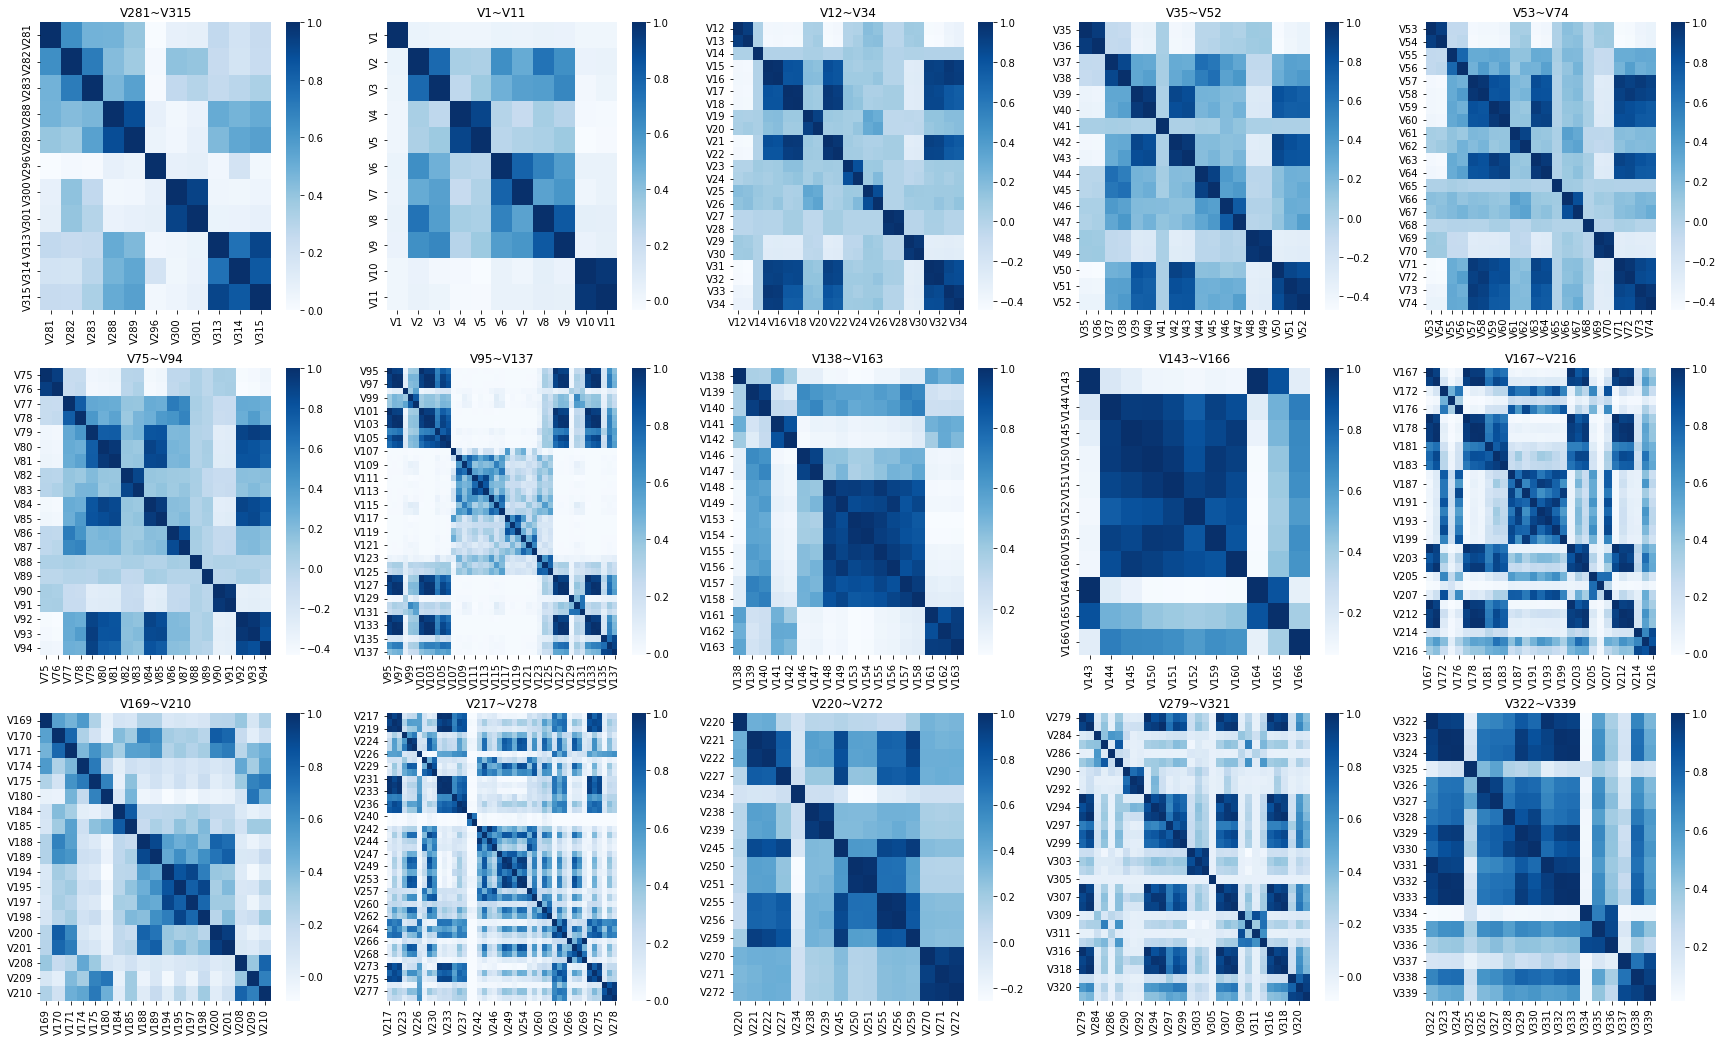

In [25]:
map_sel_first = lambda xss: [xs[0] for xs in xss]
def plot_reduced_vesta():
    reduced_vesta_features = [map_sel_first(page) for page in vesta_subset_grp_pages]
    reduced_cor_mats = [transaction_df[page].corr() for page in reduced_vesta_features]
    plot_cor_mat_seq(vesta_cor_mats)
plot_reduced_vesta()

In [26]:
def check_vesta_subsets():
    # vesta_subset_grp = [sorted(grp) for grp in vesta_subset_grp]
    prv_sz = len(union_lists(vesta_rich_grp))
    cur_sz= len(flatten_list(vesta_subset_grp))
    assert(prv_sz == cur_sz)
check_vesta_subsets()
{
        'reduced features number': len(vesta_subset_grp),
        'full' :len(flatten_list(vesta_rich_grp))
}

{'reduced features number': 155, 'full': 339}

## Counting Features

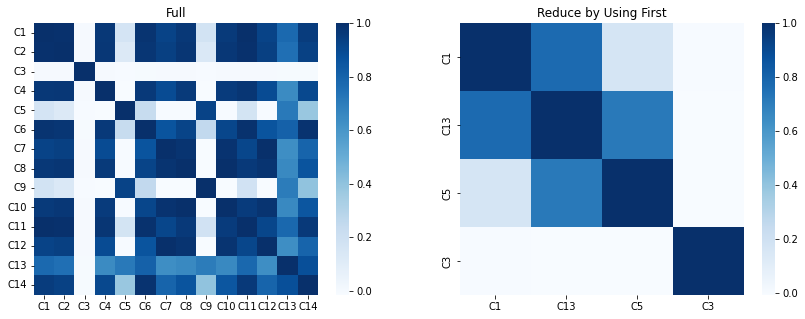

In [27]:
def visualize_reduce_features(df, cols):
    c_cor =  df[cols].corr()
    feature_subset = naive_reduce(c_cor, 0.8)

    # check size
    prv_sz = len(cols)
    cur_sz = len(flatten_list(feature_subset))
    assert(prv_sz == cur_sz)
    
    _, axs = plt.subplots(1,2, figsize=(14,5))
    sns.heatmap(c_cor, ax = axs[0], cmap='Blues')
    axs[0].set_title('Full')
    reduced_cor = df[map_sel_first(feature_subset)].corr()
    sns.heatmap(reduced_cor, ax=axs[1], cmap='Blues')
    axs[1].set_title('Reduce by Using First')
    
    return feature_subset

count_feature_subset = visualize_reduce_features(transaction_df, vesta_col_grp['counting'])

## Time Features

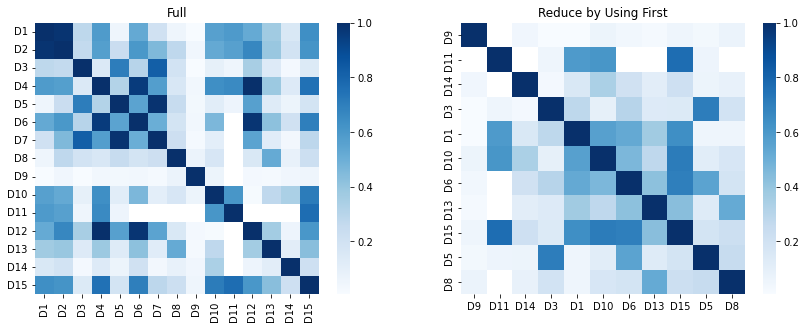

In [28]:
time_subsets = visualize_reduce_features(transaction_df, vesta_col_grp['timedelta'])

## Matching Attributes

In [29]:
{
    m:transaction_df[m].unique() for m in vesta_col_grp['match']
}

{'M1': array(['T', nan, 'F'], dtype=object),
 'M2': array(['T', nan, 'F'], dtype=object),
 'M3': array(['T', nan, 'F'], dtype=object),
 'M4': array(['M2', 'M0', nan, 'M1'], dtype=object),
 'M5': array(['F', 'T', nan], dtype=object),
 'M6': array(['T', 'F', nan], dtype=object),
 'M7': array([nan, 'F', 'T'], dtype=object),
 'M8': array([nan, 'F', 'T'], dtype=object),
 'M9': array([nan, 'F', 'T'], dtype=object)}

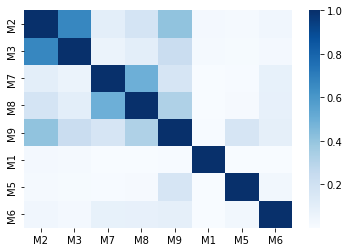

In [30]:
def local_cell_main():
    mask = transaction_df[vesta_col_grp['match']].drop('M4', axis=1).replace({'T':True, 'F':False})
    cor = mask.astype('float').corr()
    cor = abs(cor)
    tmp = '2 3 7 8 9 1 5 6'.split()
    tmp = ['M' + c for c in tmp]
    sns.heatmap(cor.loc[tmp,tmp], cmap='Blues');
local_cell_main()

## Card Attribute

In [31]:
transaction_df[vesta_col_grp['card']].head()

,card1,card2,card3,card4,card5,card6
TransactionID,,,,,,
2987000,13926,NaN,150.0,discover,142.0,credit
2987001,2755,404.0,150.0,mastercard,102.0,credit
2987002,4663,490.0,150.0,visa,166.0,debit
2987003,18132,567.0,150.0,mastercard,117.0,debit
2987004,4497,514.0,150.0,mastercard,102.0,credit


<AxesSubplot:>

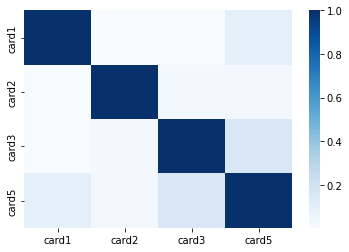

In [32]:
cor = transaction_df[vesta_col_grp['card']].corr()
sns.heatmap(abs(cor), cmap='Blues')

In [33]:
transaction_df[['card4']].value_counts(dropna=False)

card4           
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
dtype: int64

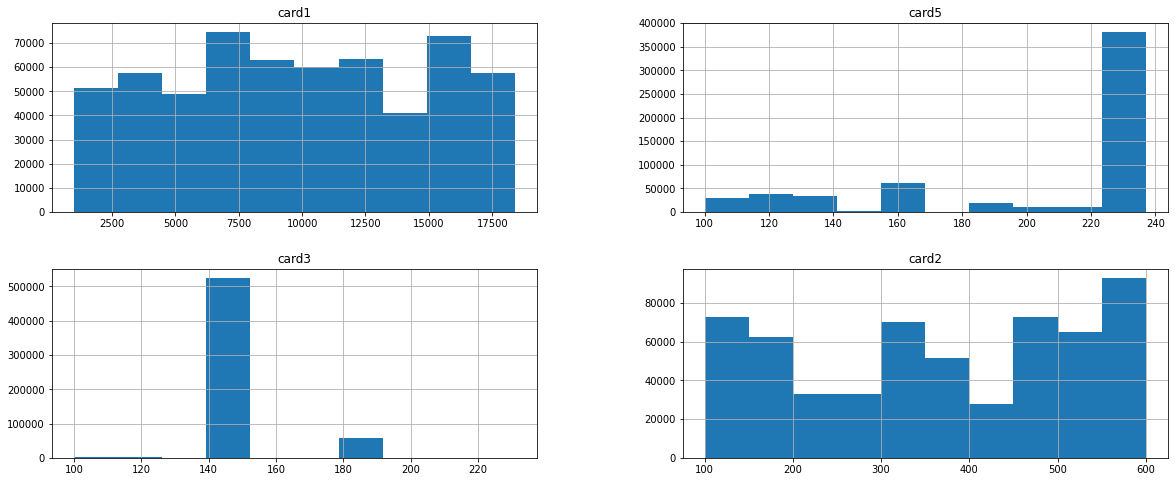

In [34]:
def local_cell_main():
    cards = vesta_col_grp['card']
    cards = set(cards).difference(['card4'])
    transaction_df[cards].hist(figsize=(20,8))
local_cell_main()

# Used Feature Groups

In [35]:
def local_cell_main():
    # quick check
    cur_sz = len(flatten_list(vesta_subset_grp))
    assert(cur_sz == 339)
    # report
    features_num = sum([len(s) for s in [count_feature_subset, time_subsets, vesta_subset_grp]])
    features_num += len(['ProductCD', 'TransactionAmt', 'dist1', 'dist2', 'addr1'])
    percent = features_num/ (len(transaction_df.columns) - 2)
    print(features_num, len(transaction_df.columns) - 2, percent)

    tmp = {
        'target': ['isFraud'],
        'input_features' : [['TransactionAmt', 'dist1', 'dist2']], 
        'categorical_cols' : vesta_col_grp['card'] + vesta_col_grp['match'] + ['ProductCD', 'addr1'],
        'time_features' : vesta_col_grp['timedelta'],
        'count_feature_subset': count_feature_subset,
        'time_subsets': time_subsets, 
        'vesta_subset_grp': vesta_subset_grp,
        'vesta_subset_grp_pages': vesta_subset_grp_pages
    }

    for nm, val in tmp.items():
        print(f'{nm} = {val}', end='\n\n')
local_cell_main()

175 391 0.4475703324808184
target = ['isFraud']

input_features = [['TransactionAmt', 'dist1', 'dist2']]

categorical_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'ProductCD', 'addr1']

time_features = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

count_feature_subset = [['C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C14'], ['C13'], ['C5', 'C9'], ['C3']]

time_subsets = [['D9'], ['D11'], ['D14'], ['D3', 'D7'], ['D1', 'D2'], ['D10'], ['D6', 'D4', 'D12'], ['D13'], ['D15'], ['D5'], ['D8']]

vesta_subset_grp = [['V281'], ['V282'], ['V283'], ['V288', 'V289'], ['V296'], ['V300', 'V301'], ['V313', 'V315'], ['V314'], ['V1'], ['V10', 'V11'], ['V2'], ['V3'], ['V4', 'V5'], ['V6'], ['V7'], ['V9', 'V8'], ['V13', 'V12'], ['V14'], ['V15', 'V16', 'V34', 'V33'], ['V17', 'V18', 'V21', 'V22', 'V31', 'V32'], ['V19', 'V20'], ['V23', 'V24'], ['V26', 'V25'], ['V27', 'V28'], [

# Missing Values

In [36]:
cols = vesta_col_grp['match']
transaction_df[cols].isna().sum()

M1    271100
M2    271100
M3    271100
M4    281444
M5    350482
M6    169360
M7    346265
M8    346252
M9    346252
dtype: int64

In [44]:
for col in cols:
    print(transaction_df[col].value_counts())

T    319415
F        25
Name: M1, dtype: int64
T    285468
F     33972
Name: M2, dtype: int64
T    251731
F     67709
Name: M3, dtype: int64
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
F    132491
T    107567
Name: M5, dtype: int64
F    227856
T    193324
Name: M6, dtype: int64
F    211374
T     32901
Name: M7, dtype: int64
F    155251
T     89037
Name: M8, dtype: int64
T    205656
F     38632
Name: M9, dtype: int64


In [39]:
cols = vesta_col_grp['card'] + ['dist1', 'dist2', 'TransactionAmt']
transaction_df[cols].isna().sum()

card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
dist1             352271
dist2             552913
TransactionAmt         0
dtype: int64

In [40]:
cols = vesta_col_grp['card'] + ['dist1', 'dist2', 'addr1']
transaction_df[cols].min()

C:\Users\LEONGT~1\AppData\Local\Temp/ipykernel_4608/2709689947.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transaction_df[cols].min()


card1    1000.0
card2     100.0
card3     100.0
card5     100.0
dist1       0.0
dist2       0.0
addr1     100.0
dtype: float64

In [41]:
transaction_df[vesta_col_grp['counting']].isna().sum()

C1     0
C2     0
C3     0
C4     0
C5     0
C6     0
C7     0
C8     0
C9     0
C10    0
C11    0
C12    0
C13    0
C14    0
dtype: int64

In [42]:
transaction_df[vesta_col_grp['timedelta'] + ['addr1']].isna().sum()

D1         1269
D2       280797
D3       262878
D4       168922
D5       309841
D6       517353
D7       551623
D8       515614
D9       515614
D10       76022
D11      279287
D12      525823
D13      528588
D14      528353
D15       89113
addr1     65706
dtype: int64

In [43]:
transaction_df[vesta_col_grp['timedelta']].min()

D1       0.0
D2       0.0
D3       0.0
D4    -122.0
D5       0.0
D6     -83.0
D7       0.0
D8       0.0
D9       0.0
D10      0.0
D11    -53.0
D12    -83.0
D13      0.0
D14   -193.0
D15    -83.0
dtype: float64

In [44]:
res = transaction_df[vesta_col_grp['features']].min() >= 0
res.all()

True

We see that vesta rich features doesn't have negative value, hence we will replace the `np.nan` with negative values (i.e.: -1). The same replacement strategy is also applied to other columns whose all values are positive or categorical.

We will use impute time features using KNNimputer.

# Identity EDA

In [45]:
with ZipFile('ieee-fraud-detection.zip', 'r') as f:
    id_df_ = pd.read_csv(f.open('train_identity.csv'))
id_df_.shape

(144233, 41)

In [46]:
id_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [47]:
id_df = pd.merge(id_df_,transaction_df[['TransactionID', 'isFraud']], on=['TransactionID'])
id_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


In [48]:
id_nan_grps = nan_groups(id_df)

In [49]:
id_nan_grps

[['id_03', 'id_04'],
 ['id_05', 'id_06'],
 ['id_07', 'id_08'],
 ['id_09', 'id_10'],
 ['id_11', 'id_28', 'id_29'],
 ['id_15', 'id_35', 'id_36', 'id_37', 'id_38'],
 ['id_22', 'id_23', 'id_27']]

In [56]:
def local_cell_main():
    vesta_id_col_grp = {'id': vesta_col_sel(id_df.columns, 'id')}
    remaining_col = set(id_df.columns) - union_lists(vesta_id_col_grp.values())
    vesta_id_col_grp['remaining'] = remaining_col
    assert(set(id_df.columns) == union_lists(vesta_id_col_grp.values()))
    return  vesta_id_col_grp
vesta_id_col_grp = local_cell_main()
vesta_id_col_grp

{'id': ['id_01',
  'id_02',
  'id_03',
  'id_04',
  'id_05',
  'id_06',
  'id_07',
  'id_08',
  'id_09',
  'id_10',
  'id_11',
  'id_12',
  'id_13',
  'id_14',
  'id_15',
  'id_16',
  'id_17',
  'id_18',
  'id_19',
  'id_20',
  'id_21',
  'id_22',
  'id_23',
  'id_24',
  'id_25',
  'id_26',
  'id_27',
  'id_28',
  'id_29',
  'id_30',
  'id_31',
  'id_32',
  'id_33',
  'id_34',
  'id_35',
  'id_36',
  'id_37',
  'id_38'],
 'remaining': {'DeviceInfo', 'DeviceType', 'TransactionID', 'isFraud'}}

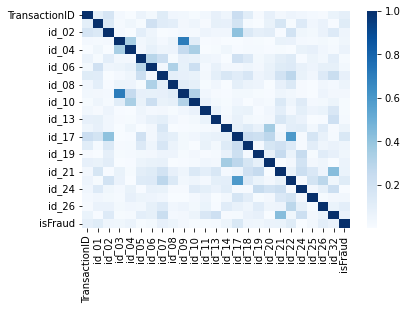

In [54]:
sns.heatmap(abs(id_df.corr()), cmap='Blues');

In [55]:
id_grp = naive_reduce(id_df.corr())
id_grp = [grp for grp in id_grp if len(grp) > 1]
id_grp

[]